<a href="https://colab.research.google.com/github/Paulo-cpereira/Identifica-o-automatica-de-castas/blob/main/Identifica%C3%A7%C3%A3o_autom%C3%A1tica_de_castas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificação automática de castas

## Mount Google Drive & Unzip Files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/ProjetoFinalLicenciatura/dataset_aumentado.zip

## Imports & Dirs

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers
from tensorflow.keras import Input
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from imutils import build_montages
from google.colab.patches import cv2_imshow
import numpy as np
import os
import cv2
import datetime

In [ ]:
os.chdir("/content/dataset_aumentado/train")
train_dir = os.getcwd()
os.chdir("/content/dataset_aumentado/validation")
validation_dir = os.getcwd()
os.chdir("/content/dataset_aumentado/test")
test_dir = os.getcwd()

### Remove photothumb files

In [ ]:
validation_labels = os.listdir(validation_dir)
for label in validation_labels:
  delete_path = validation_dir + "/" + label + "/" + "photothumb.db"
  os.remove(delete_path)
"""
os.remove(test_dir + "/" + ".ipynb_checkpoints")
"""

FileNotFoundError: ignored

IsADirectoryError: ignored

## Configuration & Data prep

### Global Variables

In [ ]:
format = "%a %b %d %H:%M %Y"
today = datetime.datetime.today()
s = today.strftime(format)
s = s.replace(" ","-")

In [ ]:
print(s)

Tue-May-17-18:36-2022


In [ ]:
IMG_SHAPE = (200, 200)
BATCH_SIZE = 16
EPOCHS = 100


BASE_OUTPUT = "/content/output/" + s
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [ ]:
if not os.path.exists(BASE_OUTPUT):
        os.makedirs(BASE_OUTPUT)

### Loading Dataset into MapDataset

In [ ]:
print("[INFO] loading train dataset...")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,image_size=(200,200),batch_size=BATCH_SIZE)
print("[INFO] loading validation dataset...")
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,image_size=(200,200),batch_size=BATCH_SIZE)
print("[INFO] loading test dataset...")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,image_size=(200,200),batch_size=BATCH_SIZE)

[INFO] loading train dataset...
Found 6718 files belonging to 12 classes.
[INFO] loading validation dataset...
Found 132 files belonging to 12 classes.
[INFO] loading test dataset...
Found 72 files belonging to 12 classes.


In [ ]:
test_ds.class_names


['Codega',
 'Malvasia Fina',
 'Malvasia Preta',
 'Malvasia Rei',
 'Moscatel Galego',
 'Mourisco Tinto',
 'Rabigato',
 'Tinta Amarela',
 'Tinta Barroca',
 'Tinta Roriz',
 'Tinto Cao',
 'Touriga Nacional']

### Data Visualization

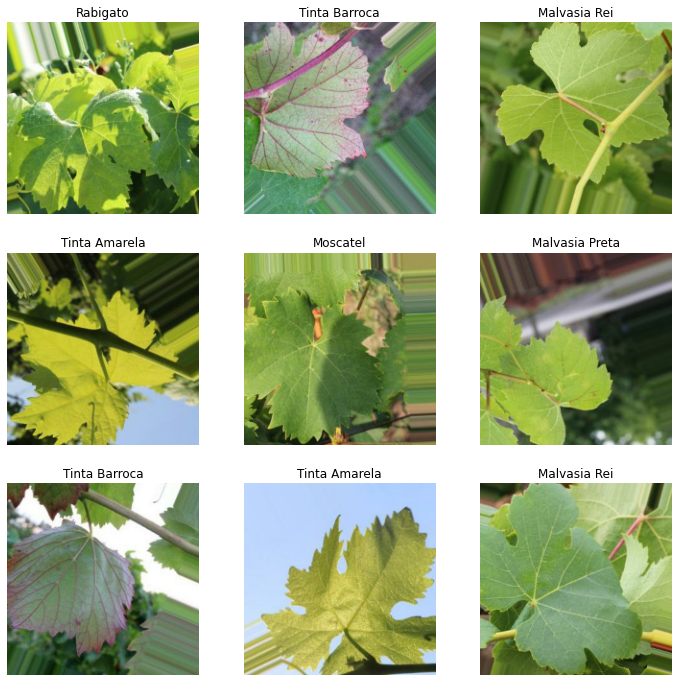

In [ ]:
import matplotlib.pyplot as plt

labels_names = train_ds.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 200, 200, 3)
(16,)


### Normalizing data (Improve)

In [ ]:
c = 0
for i in iter(test_ds):
  c += 1
print(c)

5


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
#train_image_batch, train_labels_batch = next(iter(train_dataset))

normalization_layer = tf.keras.layers.Rescaling(1./255)
validation_dataset = validation_ds.map(lambda x, y: (normalization_layer(x), y))
#validation_image_batch, validation_labels_batch = next(iter(validation_dataset))

normalization_layer = tf.keras.layers.Rescaling(1./255)
test_dataset = test_ds.map(lambda x, y: (normalization_layer(x), y))
#test_image_batch, test_labels_batch = next(iter(test_dataset))

### Making Image pairs

In [ ]:
def make_pairs(images, labels):
	# Inicialização de duas listas vazias para guardar pares (imagem, imagem) e
	# os labels dos pares para sabermos se são um par positivo ou negativo
  pairImages = []
  pairLabels = []

  # Calculei o valor total de classes no batch
  # e construi uma lista de indexs para cada classe
  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(numClasses)]

  	# Percorre todas as imagens
  for idxA in range(len(images)):
    # Seleciono a imagem atual e a classe que lhe corresponde
    currentImage = images[idxA]
    label = labels[idxA]
    # De forma random vou buscar uma imagem que pertença à mesma classe
    idxB = np.random.choice(idx[label])
    posImage = images[idxB]
    # Preparação de um par positivo e atualização das listas
    pairImages.append([currentImage, posImage])
    pairLabels.append([1])
    # Guardo os indexs das classes que não são iguais à classe atual
    # e de forma random escolho uma imagem de uma classe que não seja
    # igual à classe atual
    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]
    # Preparação de um par negativo e atualização das listas
    pairImages.append([currentImage, negImage])
    pairLabels.append([0])
  # Retorna 2 tuple dos pares de imagens e dos labels
  return (np.array(pairImages), np.array(pairLabels))

In [ ]:
# build the positive and negative image pairs
print("[INFO] preparing positive and negative pairs...")

"""#NÃO FUNCIONA
for image_batch, labels_batch in train_dataset:
  (pairTrain, labelTrain) = make_pairs(image_batch, labels_batch)
  break
for image_batch, labels_batch in validation_dataset:
  (pairValidation, labelValidation) = make_pairs(image_batch, labels_batch)
  break
for image_batch, labels_batch in test_dataset:
  (pairTest, labelTest) = make_pairs(image_batch, labels_batch)
  break
"""

train_labels = np.concatenate([y for x, y in train_dataset], axis=0)
train_images = np.concatenate([x for x, y in train_dataset], axis=0)

validation_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
validation_images = np.concatenate([x for x, y in validation_dataset], axis=0)

test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
test_images = np.concatenate([x for x, y in test_dataset], axis=0)


[INFO] preparing positive and negative pairs...


In [ ]:
(pairTrain, labelTrain) = make_pairs(train_images, train_labels)
(pairValidation, labelValidation) = make_pairs(validation_images, validation_labels)
(pairTest, labelTest) = make_pairs(test_images, test_labels)

### Pairs Visualization (Not working)

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=3))
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

InvalidArgumentError: ignored

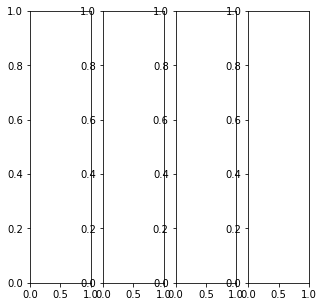

In [ ]:
visualize(pairTrain[:-1],labelTrain[:-1],  to_show=4, num_col=4)

## Building the model

### Base model (Xception)

In [ ]:
base_cnn = Xception(
    weights="imagenet", input_shape=(200,200,3), include_top=False)

base_cnn.trainable = False

83697664/83683744 [==============================] - 7s 0us/step


### Euclidean Distance Function

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

### Adding layers on Xception

In [ ]:
input = Input(shape=(200,200,3), dtype="float32")
x = base_cnn(input)

x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=1)(x)
x = Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
embedding_network = Model(input, x, name="SiameseTwin")

input_1 = Input((200,200,3), dtype="float32")
input_2 = Input((200,200,3), dtype="float32")

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

# Construção da rede siamesa
distance = Lambda(euclidean_distance)([tower_1, tower_2])
output_layer = layers.Dense(1, activation="sigmoid")(distance)
siamese = Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
embedding_network.summary()

Model: "SiameseTwin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          524352    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                       

### Usefull functions (Train Plotting & Contrastive Loss)

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """
        y_true = tf.cast(y_true, y_pred.dtype)

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

### Compiling the model

In [ ]:
# compile the model
print("[INFO] compiling model...")
siamese.compile(loss=loss(margin=1), optimizer="rmsprop", metrics=["accuracy"])
siamese.summary()


[INFO] compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 SiameseTwin (Functional)       (None, 64)           21586600    ['input_6[0][0]',                
                                                                  

### Training the model

[INFO] training model...
Epoch 1/20
2/2 [==============================] - 46s 31s/step - loss: 0.4982 - accuracy: 0.5000 - val_loss: 0.4371 - val_accuracy: 0.2656
Epoch 2/20
2/2 [==============================] - 38s 29s/step - loss: 0.4205 - accuracy: 0.5000 - val_loss: 0.3273 - val_accuracy: 0.2656
Epoch 3/20
2/2 [==============================] - 41s 31s/step - loss: 0.3894 - accuracy: 0.5000 - val_loss: 0.2766 - val_accuracy: 0.2656
Epoch 4/20
2/2 [==============================] - 39s 29s/step - loss: 0.3399 - accuracy: 0.5000 - val_loss: 0.2545 - val_accuracy: 0.2969
Epoch 5/20
2/2 [==============================] - 39s 30s/step - loss: 0.2774 - accuracy: 0.4688 - val_loss: 0.2641 - val_accuracy: 0.2656
Epoch 6/20
2/2 [==============================] - 40s 30s/step - loss: 0.2699 - accuracy: 0.5469 - val_loss: 0.2543 - val_accuracy: 0.2500
Epoch 7/20
2/2 [==============================] - 39s 30s/step - loss: 0.2592 - accuracy: 0.5000 - val_loss: 0.2557 - val_accuracy: 0.2500
Ep

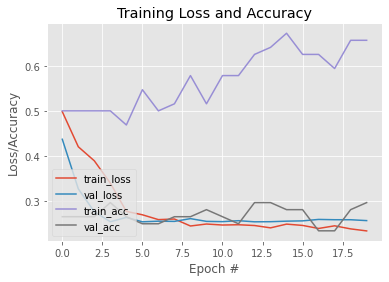

In [ ]:
print("[INFO] training model...")
history = siamese.fit(
	[pairTrain[:, 0], pairTrain[:, 1]],
  labelTrain[:],
	validation_data=([pairValidation[:, 0], pairValidation[:, 1]], labelValidation[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

# serialize the model to disk
print("[INFO] saving siamese model...")
siamese.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)